# A Map for the TRACER proposal 

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import cartopy.io.img_tiles as cimgt
import pandas as pd
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
from metpy.calc import reduce_point_density
import matplotlib.patches as mpatches
from pyproj import Geod
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import shapely.geometry as sgeom
import shapely.ops as sops
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import datetime

%run ../keyholemarkup_converter.py

%matplotlib inline

In [115]:
def namefilter(dframe, radius):
    proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])
    point_locs = proj.transform_points(ccrs.PlateCarree(), dframe['Longitude'].values, dframe['Latitude'].values)
    indexes_dc = reduce_point_density(point_locs, radius)
    ndframe = dframe[indexes_dc]
    return ndframe

def plot_points_from_df(dframe, sym='r*', ssize=12, label=None):
    iamfirst = True
    for index, row in dframe.iterrows():
        if iamfirst:
            plt.plot(row['Longitude'], row['Latitude'], sym,
                     transform=ccrs.PlateCarree(), markersize=ssize, label=label)
            iamfirst = False
        else:
            plt.plot(row['Longitude'], row['Latitude'], sym,
                     transform=ccrs.PlateCarree(), markersize=ssize)


def plot_text(dframe, dx=0.01, dy=0.01, tcol='c', valign='center'):
    for index, row in dframe.iterrows():
        plt.text(row['Longitude']+dx, row['Latitude']+dy, row['SiteName'],transform=ccrs.PlateCarree(),
                fontsize=20, color=tcol, alpha=1, weight='bold', verticalalignment=valign)
    

 # plot a scale bar with 4 subdivisions on the left side of the map
def scale_bar_left(ax, bars=4, length=None, location=(0.1, 0.05), linewidth=3, col='black',
                  fs=None, oset=2000):
    """
    ax is the axes to draw the scalebar on.
    bars is the number of subdivisions of the bar (black and white chunks)
    length is the length of the scalebar in km.
    location is left side of the scalebar in axis coordinates.
    (ie. 0 is the left side of the plot)
    linewidth is the thickness of the scalebar.
    color is the color of the scale bar
    """
    # Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    # Make tmc aligned to the left of the map,
    # vertically at scale bar location
    sbllx = llx0 + (llx1 - llx0) * location[0]
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    # Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    # Calculate a scale bar length if none has been given
    # (Theres probably a more pythonic way of rounding the number but this works)
    if not length:
        length = (x1 - x0) / 5000  # in km
        ndim = int(np.floor(np.log10(length)))  # number of digits in number
        length = round(length, -ndim)  # round to 1sf

        # Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']:
                return int(x)
            else:
                return scale_number(x - 10 ** ndim)

        length = scale_number(length)

    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx, sbx + length * 1000 / bars]
    # Plot the scalebar chunks
    barcol = 'yellow'
    for i in range(0, bars):
        # plot the chunk
        ax.plot(bar_xs, [sby, sby], transform=tmc, color=barcol, linewidth=linewidth)
        # alternate the colour
        if barcol == 'yellow':
            barcol = 'blue'
        else:
            barcol = 'yellow'
        # Generate the x coordinate for the number
        bar_xt = sbx + i * length * 1000 / bars
        # Plot the scalebar label for that chunk
        ax.text(bar_xt, sby + oset, str(round(i * length / bars)), transform=tmc,
                horizontalalignment='center', verticalalignment='bottom',
                color=col, fontsize=fs)
        # work out the position of the next chunk of the bar
        bar_xs[0] = bar_xs[1]
        bar_xs[1] = bar_xs[1] + length * 1000 / bars
    # Generate the x coordinate for the last number
    bar_xt = sbx + length * 1000
    # Plot the last scalebar label
    ax.text(bar_xt, sby + oset , str(round(length)), transform=tmc,
            horizontalalignment='center', verticalalignment='bottom',
            color=col, fontsize=fs)
    # Plot the unit label below the bar
    bar_xt = sbx + length * 1000 / 2
    bar_yt = y0 + (y1 - y0) * (location[1] / 4)
    ax.text(bar_xt, bar_yt, 'km', transform=tmc, horizontalalignment='center',
            verticalalignment='bottom', color=col, fontsize=fs)   

In [127]:
def get_siph(bb, cat=None, tvar='air_temperature'):
    # copied from the browser url box
    if cat is None:
        metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'
    else:
        metar_cat_url = cat
    # parse the xml
    metar_cat = TDSCatalog(metar_cat_url)
    # what datasets are here? only one "dataset" in this catalog
    dataset = list(metar_cat.datasets.values())[0]
    ncss_url = dataset.access_urls["NetcdfSubset"]
    ncss = NCSS(ncss_url)
    query = ncss.query()
    query.lonlat_box(**bb)
    now = datetime.datetime.now()
    last_month = now - datetime.timedelta(days=30)
    query.time_range(last_month, now)
    query.variables(tvar)
    query.accept('csv')
    data = ncss.get_data(query)
    lats = np.unique(data['latitude'])
    lons = np.unique(data['longitude'])
    
    sites = pd.DataFrame({'Latitude' : lats,
                         'Longitude' : lons})

    return sites

In [4]:
#Hidden CAMS
hidden_cams = pd.DataFrame({'CAMS' : [5005, 5006, 5012], 
                            'Latitude': [29.270278, 30.356667, 30.743889],
                           'Longitude': [-94.864167, -95.413889, -95.586111]})

In [138]:
# ex = [-100.2, -90.5, 21.7, 35.50001]
ex = [-96.2, -94.2, 28.7, 30.50001]

In [139]:
lma_locs = pd.read_csv('../data/holma.csv')
lma_locs['Longitude'] = lma_locs['lon']
lma_locs['Latitude'] = lma_locs['lat']

# Flash detection efficiency contours
lmadefname = '../data/lma_fde_ref.shp'
lma_flash_de = ShapelyFeature(Reader(lmadefname).geometries(), ccrs.PlateCarree())

In [140]:
df = pd.read_csv('../data/HGB_Monitors.txt')

In [141]:
all_met = pd.read_csv('../data/inst_at_cams_sites.csv')

In [142]:
cams_locs = pd.read_csv('../data/CAMS_locations.csv')

In [143]:
boys_locs = keyholemarkup2x('../data/stations_by_program.kml',output='gpd')
bouy_sites = pd.DataFrame({'Latitude' : boys_locs['latitude'].astype(float).values,
                         'Longitude' : boys_locs['longitude'].astype(float).values})

In [144]:
csapr_npol_locs = keyholemarkup2x('../data/CSAPR_SITE_1-28-2021.kmz',output='gpd')

#NPOL is 30'=  29.531627, -95.284372
#CSAPR is 20'=  29.531612, -95.283457

# Get rid of apostrophe in index names
csapr_npol_locs.index=csapr_npol_locs.index.str.replace('\'','', regex=True) 
# csapr_npol_sites=pd.DataFrame({'Latitude' : csapr_npol_locs['latitude'].astype(float).values,
#                          'Longitude' : boys_locs['longitude'].astype(float).values})

In [145]:
# These are lists of polygon coordinates; convert to a mean location.
def mean_lon_lat_from_poly(df, index, name):
    poly_lon, poly_lat, poly_alt = zip(*(v.split(',') for v in df.coordinates[index].split()))
    lon = np.fromiter(map(float, poly_lon), dtype=float).mean()
    lat = np.fromiter(map(float, poly_lat), dtype=float).mean()
    alt = np.fromiter(map(float, poly_alt), dtype=float).mean()
    
    return pd.DataFrame({'Latitude' : [lat], 'Longitude' : [lon],
                         'Altitude' : [alt], 'SiteName':[name] })

csapr_site = mean_lon_lat_from_poly(csapr_npol_locs, '20', 'CSAPR')
npol_site = mean_lon_lat_from_poly(csapr_npol_locs, '30', 'NPOL')


classB_airport_sites=pd.DataFrame({'Latitude' : [29.9844353, 29.6454167,],
                         'Longitude' : [-95.3414425, -95.2788889],
                         'SiteName':['IAH', 'HOU']}, index=['IAH', 'HOU'])

csucpol_site=pd.DataFrame({'Latitude' : [29.6692500],
                         'Longitude' : [-95.0641944], 'SiteName':['CSU-CPOL']})

In [146]:
arm_sites = pd.DataFrame({'Latitude' : [29.670,  29.328],
                         'Longitude' : [-95.059, -95.74],
                         'SiteName' : ['AMF1',  'ANC (approx)']})

nexrad_sites = pd.DataFrame({'Latitude' : [29.4719],
                         'Longitude' : [-95.0792],
                         'SiteName' : ['KHGX']})

In [147]:
lalo_cams = cams_locs['LongitudeLatitude']
lat_cams = [float(this_item.split(',')[1]) for this_item in lalo_cams]
lon_cams = [float(this_item.split(',')[0]) for this_item in lalo_cams]
cams_locs['Longitude'] = lon_cams
cams_locs['Latitude'] = lat_cams


In [148]:
# all_met
#cams_locs = cams_locs.append(hidden_cams)

In [149]:
# Drop rows with no CAMS ID, and drop the row whose CAMS ID is "Totals"
good_met = all_met[np.logical_not(pd.isna(all_met.CAMS)) & all_met.CAMS.str.isnumeric()].copy()

# The loop below hits a bunch of chained indexing warnings, so it is replaced with join operations, below.

# good_met['Longitude'] = np.zeros(len(good_met))
# good_met['Latitude'] = np.zeros(len(good_met))
# good_met['known_loc'] = np.zeros(len(good_met))


# i=0
# for index, row in good_met.iterrows():
#     #print(index, row.CAMS)
#     try:
#         col = cams_locs['CAMS'][cams_locs.CAMS == int(row.CAMS)].index[0]
#         good_met['Latitude'][index] = cams_locs['Latitude'][col]
#         good_met['Longitude'][index] = cams_locs['Longitude'][col]
#         good_met['known_loc'][index] = 1
#     except:
#         print('Cams unknown', row.CAMS)
#     #good_met['Latitude'][i] = cams_locs

# for index, row in good_met.iterrows():
#     try:
#         col = hidden_cams['CAMS'][hidden_cams.CAMS == int(row.CAMS)].index[0]
#         good_met['Latitude'][index] = hidden_cams['Latitude'][col]
#         good_met['Longitude'][index] = hidden_cams['Longitude'][col]
#         good_met['known_loc'][index] = 1
#     except:
#         print('Cams unknown', row.CAMS)
#     #good_met['Latitude'][i] = cams_locs


# good_met = good_met[good_met.known_loc > 0.1]

In [150]:
# Cast the CAMS column to int64
good_met['CAMSint'] = good_met.CAMS.astype('int64')
good_met = good_met.drop(columns=['CAMS']).rename(columns={'CAMSint':'CAMS'})

# Set all indexes to be the CAMS ID number, and combine the main location table with the hidden locations
idx_good_met=good_met.set_index('CAMS')
idx_cams_locs=cams_locs.set_index('CAMS')[['Longitude','Latitude']]
idx_hidden_cams=hidden_cams.set_index('CAMS')
idx_all_cams_locs = pd.concat([idx_cams_locs, idx_hidden_cams])
# print(idx_good_met.index.dtype, idx_all_cams_locs.index.dtype)
# idx_all_cams_locs

# Join the location table to . Drops any locations with a CAMS ID not in idx_good_met
join_met = idx_good_met.join(idx_all_cams_locs)
good_met = join_met[np.logical_not(pd.isna(join_met.Longitude))]
# good_met

In [151]:

inst_names = {}
is_inst = ['PMC Cab Temp', 'Ext Coef', 'D/N', 'Pres WX', 'Pres WX Obs',
       'WSA', 'WSR', 'WDR', 'Max Gust', 'STD WD', 'Out Temp', 'Dew Point',
       'Int Temp', 'Rel Humid', 'Vis', 'Slr Rad', 'UV Rad', 'Net Rad', 'Press',
       'Precip']

does_it_have = {}

for an_instrument in is_inst:
    availability = good_met[an_instrument] > 0.9
    does_it_have.update({an_instrument : availability})


In [152]:
basic_met = np.logical_and(does_it_have['Out Temp'], does_it_have['WDR'])
rad = np.logical_and(does_it_have['Slr Rad'], basic_met)
rad_sites = good_met[rad]
basic_sites = good_met[basic_met]

In [153]:
# coordinates from original TRACER proposal
"""
AMF1 at La Porte airport 29.666944N, -95.063611W
C-SAPR2 at Manvel-Croix Park, 29.520278N, -95.392500W
ANC site near Hungerford Texas, 29.3991N, -96.0769W
KHGX 29.4719  -95.0792 
"""

'\nAMF1 at La Porte airport 29.666944N, -95.063611W\nC-SAPR2 at Manvel-Croix Park, 29.520278N, -95.392500W\nANC site near Hungerford Texas, 29.3991N, -96.0769W\nKHGX 29.4719  -95.0792 \n'

In [160]:
def circle(geod, lon, lat, radius, n_samples=360):
    """
    Return the coordinates of a geodetic circle of a given
    radius about a lon/lat point.

    Radius is in meters in the geodetic's coordinate system.

    """
    lons, lats, back_azim = geod.fwd(np.repeat(lon, n_samples),
                                     np.repeat(lat, n_samples),
                                     np.linspace(360, 0, n_samples),
                                     np.repeat(radius, n_samples),
                                     radians=False,
                                     )
    return lons, lats

def rring(radii_km, ctr_lons, ctr_lats, intersect=(0,1), color=(1.0,1.0,0.8,0.25), edgecolor=(0.0,0.0,0.0,1.0)):
    """Plot range rings for each center position at the radii indicated in radii_km.
    
    Also find the intersection of all annuli (donuts) formed by the circles corresponding
        to the pair of radii indexed by the values of the 2-tuple intersect. 
    """
    geod = Geod(ellps='WGS84')
    n_samples = 80
    geoms = []
    donuts = []

    for clon, clat in zip(ctr_lons, ctr_lats):
        rad_pair = []
        for irad, radius_km in enumerate(radii_km):
            lons, lats = circle(geod, clon, clat, radius_km * 1e3, n_samples)
            geom = sgeom.Polygon(zip(lons, lats))
            if irad in intersect:
                rad_pair.append(geom)
            geoms.append(geom)
        # Time to make a donut
        donuts.append(rad_pair[1].difference(rad_pair[0]))
#     overlap = sops.unary_union(donuts) # needs to be intersection to find exclusive overlap of the donuts
    
    
    plt.gca().add_geometries(geoms, ccrs.PlateCarree(), facecolor='none',
                                 edgecolor=edgecolor, linewidth=2, zorder=10)

    plt.gca().add_geometries(donuts, ccrs.PlateCarree(), facecolor=color, zorder=9
                            )#                             edgecolor='none', linewidth='none')


In [155]:
mybb = {'north' : ex[3], 'south': ex[2], 'east' : ex[0], 'west' : ex[1]}
nws_sites = get_siph(mybb)

/Users/ebruning/miniconda3/envs/tracer-env/lib/python3.6/site-packages/siphon/ncss.py:433: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  converters={'date': lambda s: parse_iso_date(s.decode('utf-8'))})


/Users/ebruning/miniconda3/envs/tracer-env/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/Users/ebruning/miniconda3/envs/tracer-env/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/Users/ebruning/miniconda3/envs/tracer-env/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor re

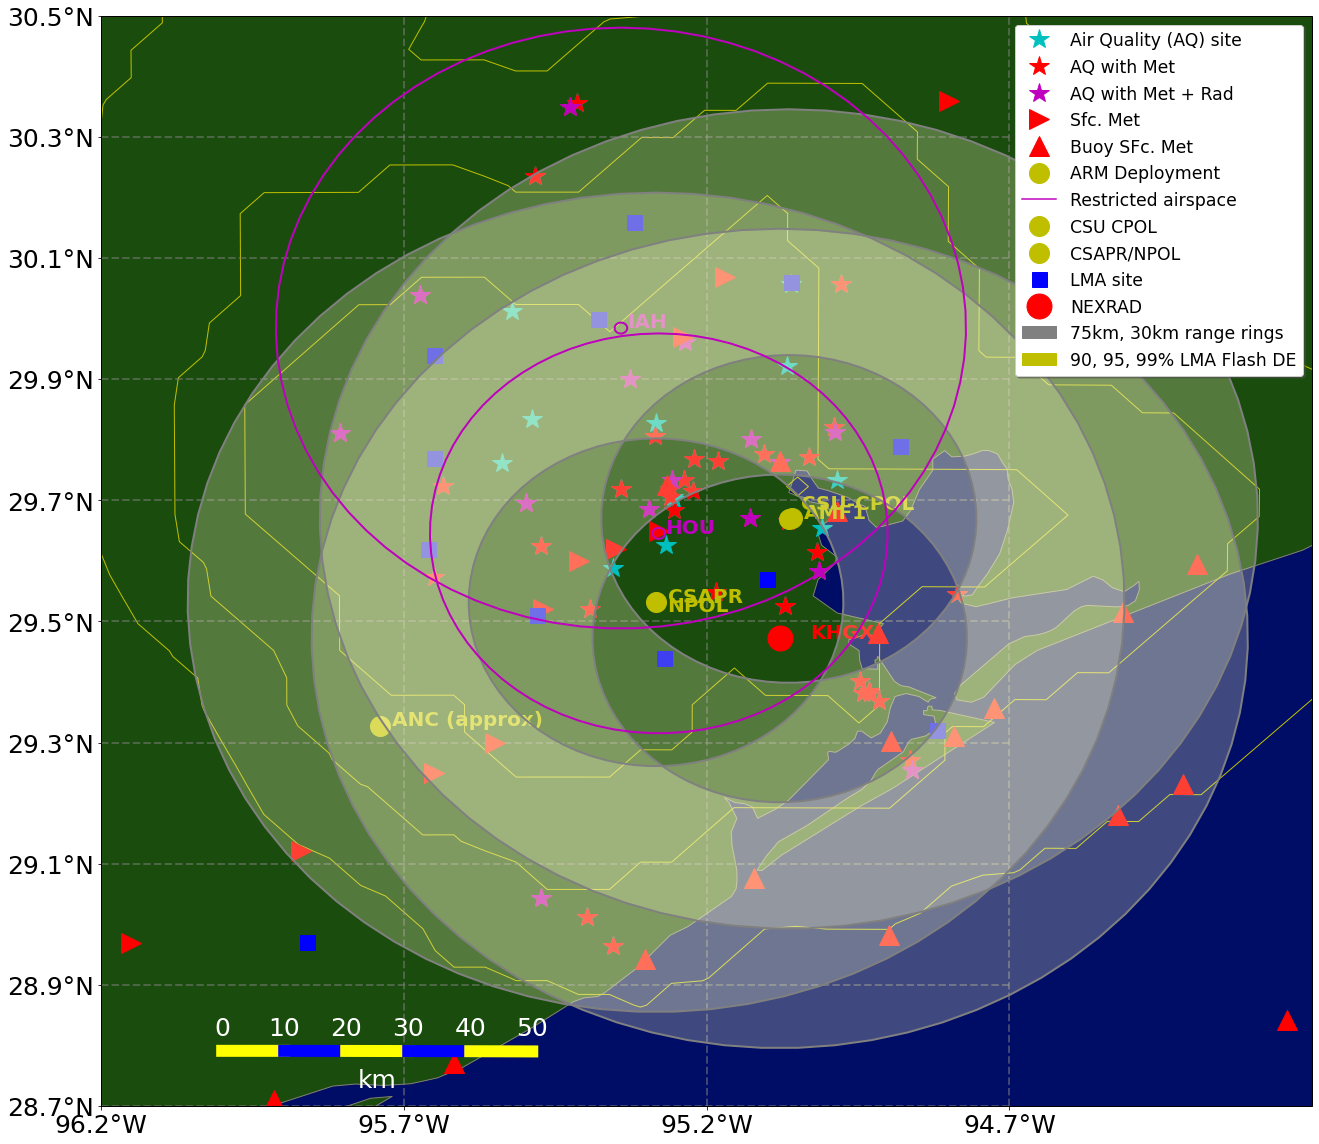

In [163]:
i = 0
myf = plt.figure(figsize=[20,16])
ax = plt.axes(projection=ccrs.PlateCarree(), facecolor=(0.0, 0.1, 0.5))


ax.set_extent(ex)

lat_lines = np.arange(np.around(ex[2], decimals=1), 
                      ex[3], .2)
lon_lines = np.arange(np.around(ex[0],decimals=1),
                      ex[1], .5)

#lat_lines = np.concatenate((lat_lines, np.array([31.])))


# Put a background image on for nice sea rendering.
# ax.background_img(resolution='low', extent=ex)

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces_filled = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces',
    scale='10m',)
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',)
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', name='coastline')

# request = cimgt.GoogleTiles(style='satellite')
# request = cimgt.Stamen(style='terrain')
if False: #len(request.imgs) > 0:
    # Note that if run repeatedy, using the tiles can get you banned from Google's tile requests.
    ax.add_feature(coast, edgecolor='k', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray', facecolor='none')
    ax.add_image(request, 8, zorder=0)
else:
    ax.add_feature(coast, edgecolor='k', facecolor=(0.0,0.05,0.4))
    ax.add_feature(states_provinces_filled, edgecolor='gray', facecolor=(0.1, 0.3, 0.05))


line_collection = boys_locs.plot(marker='*', color='green',ax = ax)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--',
                 xlocs=lon_lines, ylocs=lat_lines)

plot_points_from_df(good_met, 'c*', ssize=20, label='Air Quality (AQ) site')
plot_points_from_df(basic_sites, 'r*', ssize=20, label='AQ with Met')
plot_points_from_df(rad_sites, 'm*', ssize=20, label='AQ with Met + Rad')
plot_points_from_df(nws_sites, 'r>', ssize=20, label='Sfc. Met')
plot_points_from_df(bouy_sites, 'r^', ssize=20, label='Buoy SFc. Met')

plot_points_from_df(arm_sites, 'yo', ssize=20, label='ARM Deployment')
plot_points_from_df(classB_airport_sites, 'm', ssize=20, label='Restricted airspace')
plot_points_from_df(csucpol_site, 'yo', ssize=20, label='CSU CPOL')
plot_points_from_df(csapr_site, 'yo', ssize=20, label='CSAPR/NPOL')

plot_text(arm_sites, dx=0.02, tcol='y')
plot_text(csapr_site, dx=0.02, tcol='y', )
plot_text(npol_site, dx=0.02, tcol='y', valign='top')
plot_text(csucpol_site, dx=0.02, tcol='y', valign='bottom')
plot_text(classB_airport_sites, dx=0.01, tcol='m')



plot_points_from_df(lma_locs, 'bs', ssize=15, label='LMA site')

#{'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'}
plot_points_from_df(nexrad_sites, 'ro', ssize=25, label='NEXRAD')
plot_text(nexrad_sites, dx=0.05, tcol='r')

radar_ring_color=(0.5,)*3
rring((30, 75), [csapr_site['Longitude'][0], nexrad_sites['Longitude'][0], csucpol_site['Longitude'][0]], 
                [csapr_site['Latitude'][0], nexrad_sites['Latitude'][0], csucpol_site['Latitude'][0]],
                edgecolor=radar_ring_color)

rring((1.0, 36.6), [classB_airport_sites['Longitude']['HOU']], [classB_airport_sites['Latitude']['HOU']], color=(0.0,0.0,0.0,0.0), edgecolor='m' )
rring((1.0, 55.0), [classB_airport_sites['Longitude']['IAH']], [classB_airport_sites['Latitude']['IAH']], color=(0.0,0.0,0.0,0.0), edgecolor='m'  )

extraString = '75km, 30km range rings'
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(mpatches.Patch(color=radar_ring_color, label=extraString))

ax.add_feature(lma_flash_de, facecolor='none', edgecolor='y')
handles.append(mpatches.Patch(color='y', label='90, 95, 99% LMA Flash DE'))


scale_bar_left(plt.gca(), bars=5, linewidth=12, fs=25, col='white', length=50)

legend = plt.legend(shadow=True, fontsize='xx-large', handles=handles)
legend.set_zorder(20)  # put the legend on top
plt.tight_layout()


plt.savefig('../images/texas_HGB_sites.png', dpi=300)
plt.show()


## Save CAMS data tables as docx

In [28]:
import docx

In [21]:
good_met

,CAMS,PMC Cab Temp,Ext Coef,D/N,Pres WX,Pres WX Obs,WSA,WSR,WDR,Max Gust,...,Vis,Slr Rad,UV Rad,Net Rad,Press,Precip,CAMS.1,Longitude,Latitude,known_loc
0,1,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,-95.221,29.768,1.0
1,8,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,1.0,NaN,8,-95.326,29.901,1.0
3,11,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,11,-95.397,29.011,1.0
4,15,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,15,-95.126,29.802,1.0
6,26,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,26,-95.674,30.039,1.0
7,35,4.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,35,-95.128,29.670,1.0
10,45,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,45,-95.015,29.583,1.0
12,53,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,53,-95.499,29.696,1.0
13,78,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,78,-95.425,30.350,1.0
15,84,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,84,-95.393,29.520,1.0


In [186]:
drops = ['known_loc', 'CAMS.1', 'Pres WX Obs', 'PMC Cab Temp', 'Int Temp']

new_rad = rad_sites.replace(np.nan, 'No', regex=True)
new_rad = new_rad.replace(1, 'Yes', regex=True)
new_rad = new_rad.replace(2, 'Yes', regex=True)
new_rad = new_rad.replace(3, 'Yes', regex=True)
new_rad = new_rad.replace(4, 'Yes', regex=True)
new_rad = new_rad.drop(drops, axis=1)




In [187]:
new_met = good_met.drop(rad_sites.index)
really_new_met = new_met.drop(basic_sites.index, errors='ignore')
really_new_met = really_new_met.replace(np.nan, 'No', regex=True)
really_new_met = really_new_met.replace(1, 'Yes', regex=True)
really_new_met = really_new_met.replace(2, 'Yes', regex=True)
really_new_met = really_new_met.drop(drops, axis=1)


In [188]:
new_basic = basic_sites.drop(really_new_met.index, errors='ignore')
new_basic = basic_sites.drop(new_rad.index, errors='ignore')

new_basic = new_basic.replace(np.nan, 'No', regex=True)
new_basic = new_basic.replace(1, 'Yes', regex=True)
new_basic = new_basic.replace(2, 'Yes', regex=True)
new_basic = new_basic.replace(3, 'Yes', regex=True)
new_basic = new_basic.replace(4, 'Yes', regex=True)
new_basic = new_basic.drop(drops, axis=1)



In [251]:
aq_drops = ['AQS', 'FID', 'Region', 'County', 'Latitude', 'Longitude', 'SiteName','SiteOwner']

In [267]:
new_df = df[df['CAMS'] < 10000]

new_df['CAMS'] = new_df['CAMS'].astype(int)

poo = new_df.CAMS.isin(good_met.CAMS.astype(int))

new_df = new_df[poo]

new_df = new_df.replace(1.0, 'Yes', regex=True)
new_df = new_df.replace(0, 'No', regex=True)
new_df = new_df.replace(6.16162e+06, 'Not Avail', regex=True)
new_df = new_df.drop(aq_drops, axis=1)

for key in new_df.keys():
    if len(new_df[key].unique()) == 1:
        new_df = new_df.drop([key], axis=1)






/Users/scollis/anaconda3/envs/tracer-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [268]:
new_df

,CAMS,O3,CO,SO2,H2S,NOX,NOY,PM10FRM,PM25BETA,PM25SPEC,PM25TEOM,Canister,EventCanis,AutoGC,SRIGC,TNMOC
1,11,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No
2,84,Yes,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No
3,1012,No,No,Yes,No,No,No,No,No,Yes,No,No,No,No,No,No
4,1016,Yes,No,No,No,Yes,No,No,No,No,No,No,No,Yes,No,No
7,696,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No
9,1022,No,No,Yes,Yes,No,No,No,No,No,No,Yes,No,No,No,No
10,620,Yes,No,No,No,Yes,No,No,No,No,No,No,No,Yes,No,No
11,571,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No
16,1034,Yes,No,No,No,Yes,No,No,No,Yes,Yes,No,No,No,No,No
17,8,Yes,No,No,No,Yes,Yes,Yes,No,Yes,Yes,No,No,No,No,No


In [189]:
new_rad

,CAMS,Ext Coef,D/N,Pres WX,WSA,WSR,WDR,Max Gust,STD WD,Out Temp,Dew Point,Rel Humid,Vis,Slr Rad,UV Rad,Net Rad,Press,Precip,Longitude,Latitude
1,8,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,Yes,No,-95.326,29.901
4,15,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,No,-95.126,29.802
6,26,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,No,-95.674,30.039
7,35,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,No,-95.128,29.670
10,45,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,Yes,No,No,No,No,-95.015,29.583
12,53,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,Yes,No,No,No,No,-95.499,29.696
13,78,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,Yes,No,No,No,No,-95.425,30.350
22,403,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,-95.257,29.734
31,416,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,-95.295,29.686
37,559,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,Yes,No,No,No,No,-95.806,29.811


In [192]:
new_basic

,CAMS,Ext Coef,D/N,Pres WX,WSA,WSR,WDR,Max Gust,STD WD,Out Temp,Dew Point,Rel Humid,Vis,Slr Rad,UV Rad,Net Rad,Press,Precip,Longitude,Latitude
0,1,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,-95.221000,29.768000
3,11,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,-95.397000,29.011000
15,84,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,-95.393000,29.520000
16,96,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,-94.787000,29.546000
17,145,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,-95.018000,29.615000
18,148,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,-95.031000,29.771000
19,167,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,-95.238000,29.734000
20,169,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,-95.261000,29.706000
21,243,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,Yes,-95.066000,29.665000
25,404,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,-95.285000,29.807000


In [196]:

# i am not sure how you are getting your data, but you said it is a
# pandas data frame
df = really_new_met

# open an existing document
doc = docx.Document('../tables.docx')

# add a table to the end and create a reference variable
# extra row is so we can add the header row
t = doc.add_table(df.shape[0]+1, df.shape[1])

# add the header rows.
for j in range(df.shape[-1]):
    t.cell(0,j).text = df.columns[j]

# add the rest of the data frame
for i in range(df.shape[0]):
    for j in range(df.shape[-1]):
        t.cell(i+1,j).text = str(df.values[i,j])

# save the doc
doc.save('../tables.docx')

In [198]:

# i am not sure how you are getting your data, but you said it is a
# pandas data frame
df = new_basic

# open an existing document
doc = docx.Document('../tables.docx')

# add a table to the end and create a reference variable
# extra row is so we can add the header row
t = doc.add_table(df.shape[0]+1, df.shape[1])

# add the header rows.
for j in range(df.shape[-1]):
    t.cell(0,j).text = df.columns[j]

# add the rest of the data frame
for i in range(df.shape[0]):
    for j in range(df.shape[-1]):
        t.cell(i+1,j).text = str(df.values[i,j])

# save the doc
doc.save('../tables.docx')

In [199]:

# i am not sure how you are getting your data, but you said it is a
# pandas data frame
df = new_rad

# open an existing document
doc = docx.Document('../tables.docx')

# add a table to the end and create a reference variable
# extra row is so we can add the header row
t = doc.add_table(df.shape[0]+1, df.shape[1])

# add the header rows.
for j in range(df.shape[-1]):
    t.cell(0,j).text = df.columns[j]

# add the rest of the data frame
for i in range(df.shape[0]):
    for j in range(df.shape[-1]):
        t.cell(i+1,j).text = str(df.values[i,j])

# save the doc
doc.save('../tables.docx')

In [202]:
df

,FID,Region,AQS,County,CAMS,SiteName,Latitude,Longitude,SiteOwner,O3,...,TSPLead,SVOC,Canister,EventCanis,AutoGC,SRIGC,Carbonyl,TNMOC,PMCoarse,SulfurAnly
0,20,12.0,480390618.0,BRAZORIA,6.180000e+02,Danciger,29.144291,-95.756601,Brazoria County - Sweeny Industry Group,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,21,12.0,480391003.0,BRAZORIA,1.100000e+01,Clute,29.010841,-95.397744,TCEQ,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22,12.0,480391004.0,BRAZORIA,8.400000e+01,Manvel Croix Park,29.520443,-95.392509,TCEQ,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23,12.0,480391012.0,BRAZORIA,1.012000e+03,Freeport South Avenue I,28.964430,-95.354830,TCEQ,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24,12.0,480391016.0,BRAZORIA,1.016000e+03,Lake Jackson,29.043759,-95.472946,TCEQ,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,25,12.0,480391607.0,BRAZORIA,1.607000e+03,Oyster Creek,29.010556,-95.313333,Freeport LNG,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,34,12.0,480711606.0,CHAMBERS,1.606000e+03,UH Smith Point,29.545789,-94.781386,University of Houston,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,72,12.0,481570696.0,FORT BEND,6.960000e+02,UH Sugarland,29.574100,-95.649700,University of Houston,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,73,12.0,481670004.0,GALVESTON,0.000000e+00,Texas City Fire Station,29.384444,-94.930833,Galveston City-County Health Department,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,74,12.0,481670005.0,GALVESTON,1.022000e+03,Texas City Ball Park,29.385234,-94.931520,TCEQ,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [269]:
# i am not sure how you are getting your data, but you said it is a
# pandas data frame
df = new_df

# open an existing document
doc = docx.Document('../tables.docx')

# add a table to the end and create a reference variable
# extra row is so we can add the header row
t = doc.add_table(df.shape[0]+1, df.shape[1])

# add the header rows.
for j in range(df.shape[-1]):
    t.cell(0,j).text = df.columns[j]

# add the rest of the data frame
for i in range(df.shape[0]):
    for j in range(df.shape[-1]):
        t.cell(i+1,j).text = str(df.values[i,j])

# save the doc
doc.save('../tables.docx')

In [270]:
new_df.keys()

Index(['CAMS', 'O3', 'CO', 'SO2', 'H2S', 'NOX', 'NOY', 'PM10FRM', 'PM25BETA',
       'PM25SPEC', 'PM25TEOM', 'Canister', 'EventCanis', 'AutoGC', 'SRIGC',
       'TNMOC'],
      dtype='object')

In [ ]:
"""
Real-time monitoring since: Tuesday, March 20, 2007
Current status: Active
Continuous monitors located at this site:
Met Data
Ozone
Oxides of Nitrogen
Fine Particulates (PM-2.5)
Parameters currently being monitored:
Pollution parameters:
Nitric Oxide
Nitrogen Dioxide
Oxides of Nitrogen
Ozone
PM-2.5 (Local Conditions) Acceptable
Meteorological parameters:
Wind Speed
Resultant Wind Speed
Resultant Wind Direction
Maximum Wind Gust
Standard Deviation of Horizontal Wind Direction
Outdoor Temperature
Dew Point Temperature
Relative Humidity
Solar Radiation
Parameters that have been monitored but are no longer active:
Pollution parameters:
NOy
Nitric Oxide"""